In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("NDugar/debertav3-mnli-snli-anli")
model = AutoModelForSequenceClassification.from_pretrained("NDugar/debertav3-mnli-snli-anli",num_labels=3)

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

class FactVerificationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer =AutoTokenizer.from_pretrained("NDugar/debertav3-mnli-snli-anli")  # Change to the desired model name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        encoded_input = self.tokenizer.encode_plus(
            item['Claim'],
            item['evidence'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        label = item['label']
        return {
            'input_ids': encoded_input['input_ids'].squeeze(),
            'attention_mask': encoded_input['attention_mask'].squeeze(),
            'label': torch.tensor(label)
        }

In [4]:
import json

# Step 1: Open the JSON file
with open('/kaggle/input/aishaaaaaaaaaaaaaa/test - Copy.json', 'r', encoding='utf-8') as file:
    # Step 2: Parse the JSON data
    testing_dataset = json.load(file)



In [10]:
evaluation_dataset = FactVerificationDataset(testing_dataset)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate the model on the testing dataset
model.eval()


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [12]:
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=16, shuffle=False)

correct_predictions = 0
total_predictions = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Accuracy: 0.4136460554371002


In [15]:
correct_predictions = 0
total_predictions = 0
predicted_labels_list = []  # List to store predicted labels
original_labels_list = []   # List to store original labels

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

    # Append predicted and original labels to their respective lists
    predicted_labels_list.extend(predicted_labels.cpu().numpy())
    original_labels_list.extend(labels.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

# Now you can work with predicted_labels_list and original_labels_list outside the loop


Accuracy: 0.4136460554371002


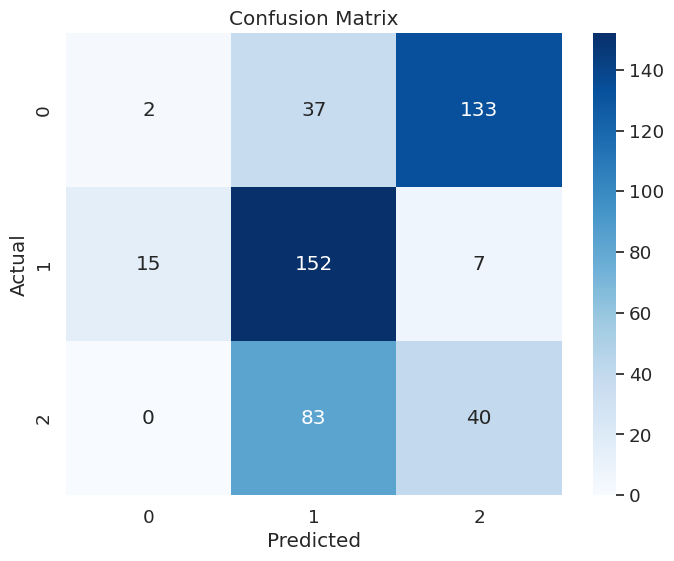

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming correct_predictions and predicted_labels are your data
correct_predictions = [0, 1, 2, 0, 1, 2, 0, 1, 2]
predicted_labels = [0, 1, 2, 1, 0, 1, 2, 0, 2]

# Get unique labels from the data
labels = [0,1,2]

# Create the confusion matrix
conf_matrix = confusion_matrix(original_labels_list, predicted_labels_list, labels=labels)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import classification_report

# Assuming original_labels_list and predicted_labels_list are your data


# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute the classification report
class_report = classification_report(original_labels_list, predicted_labels_list, labels=labels)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.01      0.02       172
           1       0.56      0.87      0.68       174
           2       0.22      0.33      0.26       123

    accuracy                           0.41       469
   macro avg       0.30      0.40      0.32       469
weighted avg       0.31      0.41      0.33       469

